$$ ITI \space AI-Pro: \space Intake \space 44 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.preprocessing.image.ImageDataGenerator` or `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**, and **Dropout** of $20-30\%$.
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [ ]:
# pip install gdown

In [1]:
import numpy as np

import gdown
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

# `+` Seed Value

In [ ]:
SEED = 907

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=39613523-1db9-4017-b533-cb792a686a36
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 70.3MB/s]


'Lung_Data.zip'

In [ ]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
BATCH_SIZE = 8

In [ ]:
# Training & Validation Generator/Dataset
train_img_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    rescale=1.0/255.0,
    validation_split=0.15
)

val_img_gen = ImageDataGenerator(
                   rescale=1/255.,
                   validation_split=0.15
                   )

In [ ]:
train_image_ds = train_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='training',
    classes=['grey'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

train_mask_ds = train_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='training',
    classes=['mask'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

Found 184 images belonging to 1 classes.
Found 184 images belonging to 1 classes.


In [ ]:
val_image_ds = val_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='validation',
    classes=['grey'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

val_mask_ds = val_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='validation',
    classes=['mask'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

Found 32 images belonging to 1 classes.
Found 32 images belonging to 1 classes.


### Preview the Images

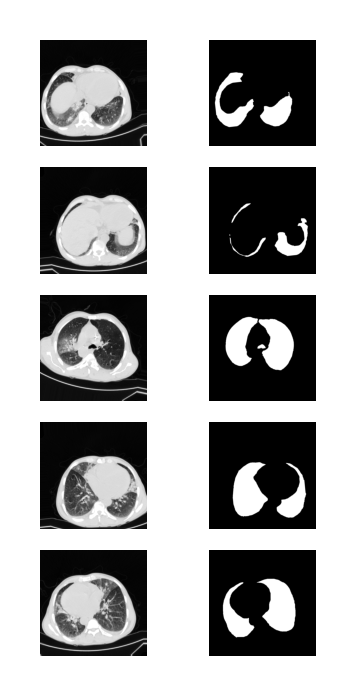

In [ ]:
# Preview Images
plt.figure(figsize=(1, 2), dpi=400)
images, masks = train_image_ds.next(), train_mask_ds.next()
for i in range(5):
  plt.subplot(5, 2, i*2+1)
  plt.imshow(images[i], cmap='gray')
  plt.axis('off')
  plt.subplot(5, 2, i*2+2)
  plt.imshow(masks[i], cmap='gray')
  plt.axis('off')

## `+` Set Global Parameters

In [ ]:
# Hyperparameters
BATCH_SIZE  =8
EPOCHS      =1

## `i` Model Design

In [ ]:
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import *

# def unet(sz=image_size):
#     x = Input(sz)
#     inputs = x
    
#     #downsampling
#     f = 8 #number of filters
#     layers = []
#     for i in range(6):
#         x = Conv2D(f, 3, activation='relu',padding='same')(x)
#         x = Conv2D(f, 3, activation='relu',padding='same')(x)
#         layers.append(x)
#         x = MaxPooling2D()(x)
#         f = f*2
#     ff2 = 64

#     #bottleneck
#     j = len(layers)-1
#     x = Conv2D(f, 3, activation='relu',padding='same')(x)
#     x = Conv2D(f, 3, activation='relu',padding='same')(x)
#     x = Conv2DTranspose(ff2, 2, strides=(2,2),padding='same')(x)
#     x = Concatenate(axis=3)([x,layers[j]])
#     j = j-1
    
#     #upsampling
#     for i in range(5):
#         ff2 = ff2//2
#         f = f//2
#         x = Conv2D(f, 3, activation='relu',padding='same')(x)
#         x = Conv2D(f, 3, activation='relu',padding='same')(x)
#         x = Conv2DTranspose(ff2, 2, strides=(2,2),padding='same')(x)
#         x = Concatenate(axis=3)([x,layers[j]])
#         j = j-1
#     #classification 
#     x = Conv2D(f, 3, activation='relu',padding='same')(x)
#     x = Conv2D(f, 3, activation='relu',padding='same')(x)
#     outputs = Conv2D(1, 1, activation = 'sigmoid')(x)
#     model = Model(inputs=[inputs], outputs = [outputs])
#     model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['mean_iou'])
    
#     return model

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)
    b1 = Dropout(0.3)(b1)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# input image size is (512, 512, 1)
model = build_unet((512, 512, 1))
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 512, 512, 32)         320       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 512, 512, 32)         128       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 512, 512, 32)         0         ['batch_normalization_36[0

## `ii` Model Compilation & Training

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_segment_gen = zip(train_image_ds, train_mask_ds)
val_segment_gen = zip(val_image_ds, val_mask_ds)

In [ ]:
call_train = model.fit(train_segment_gen,
          epochs=50,
          steps_per_epoch=train_image_ds.samples//BATCH_SIZE,
          validation_data=val_segment_gen,
          validation_steps=val_image_ds.samples//BATCH_SIZE
          )

Epoch 1/50
23/23 [==============================] - 59s 1s/step - loss: 0.2783 - accuracy: 0.9214 - val_loss: 0.7134 - val_accuracy: 0.4699
Epoch 2/50
23/23 [==============================] - 24s 1s/step - loss: 0.1409 - accuracy: 0.9807 - val_loss: 1.8139 - val_accuracy: 0.4073
Epoch 3/50
23/23 [==============================] - 24s 1s/step - loss: 0.1079 - accuracy: 0.9850 - val_loss: 4.2019 - val_accuracy: 0.0422
Epoch 4/50
23/23 [==============================] - 24s 1s/step - loss: 0.0841 - accuracy: 0.9863 - val_loss: 3.6087 - val_accuracy: 0.0506
Epoch 5/50
23/23 [==============================] - 24s 1s/step - loss: 0.0742 - accuracy: 0.9853 - val_loss: 11.5747 - val_accuracy: 0.0403
Epoch 6/50
23/23 [==============================] - 24s 1s/step - loss: 0.0500 - accuracy: 0.9896 - val_loss: 3.8033 - val_accuracy: 0.0495
Epoch 7/50
23/23 [==============================] - 24s 1s/step - loss: 0.0420 - accuracy: 0.9894 - val_loss: 6.2819 - val_accuracy: 0.0446
Epoch 8/50
23/23 [=

## `iii` Model Evaluation

In [ ]:
# model on the training data
train_evaluation = model.evaluate(train_segment_gen, steps=train_image_ds.samples // BATCH_SIZE)

# model on the validation data
val_evaluation = model.evaluate(val_segment_gen, steps=val_image_ds.samples // BATCH_SIZE)

print("Training Accuracy:", train_evaluation[1])
print("Training Loss:", train_evaluation[0])
print("Validation Accuracy:", val_evaluation[1])
print("Validation Loss:", val_evaluation[0])


4/4 [==============================] - 1s 216ms/step - loss: 0.0345 - accuracy: 0.9885
Training Accuracy: 0.9920978546142578
Training Loss: 0.011530202813446522
Validation Accuracy: 0.9884998798370361
Validation Loss: 0.034504082053899765


## `iv` Result Visualization

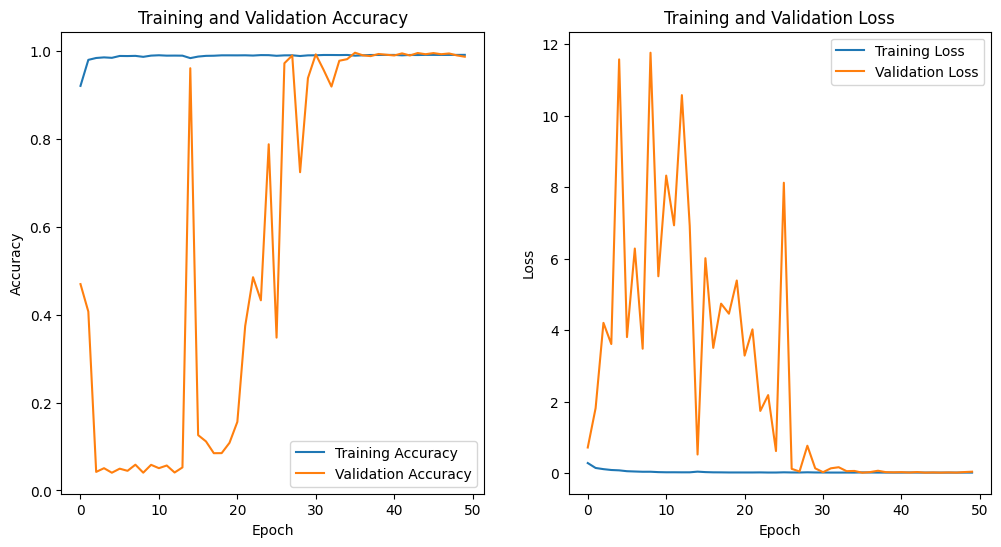

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(call_train.history['accuracy'], label='Training Accuracy')
plt.plot(call_train.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(call_train.history['loss'], label='Training Loss')
plt.plot(call_train.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
# Function to plot images with masks and predicted masks
def plot_images_with_masks(images, true_masks, pred_masks, thresholds):
    num_images = len(images)

    fig, axes = plt.subplots(num_images, len(thresholds) + 2, figsize=(15, 5*num_images))

    for i in range(num_images):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title('Input Image')

        axes[i, 1].imshow(true_masks[i], cmap='gray')
        axes[i, 1].set_title('True Mask')

        for j, thresh in enumerate(thresholds):
            pred_mask = pred_masks[i] > thresh
            axes[i, j+2].imshow(pred_mask, cmap='gray')
            axes[i, j+2].set_title(f'Thresh={thresh}')

    plt.tight_layout()
    plt.show()

# Five samples only
num_samples_to_visualize = 5

#images and masks
visualize_images = []
visualize_true_masks = []
for _ in range(num_samples_to_visualize):
    batch_images = next(val_image_ds)
    batch_true_masks = next(val_mask_ds)
    visualize_images.append(batch_images[0])
    visualize_true_masks.append(batch_true_masks[0])

# lists to numpy arrays
visualize_images = np.array(visualize_images)
visualize_true_masks = np.array(visualize_true_masks)

# masks for the chosen validation samples
pred_masks = model.predict(visualize_images)

# different thresholds
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

1/1 [==============================] - 0s 25ms/step


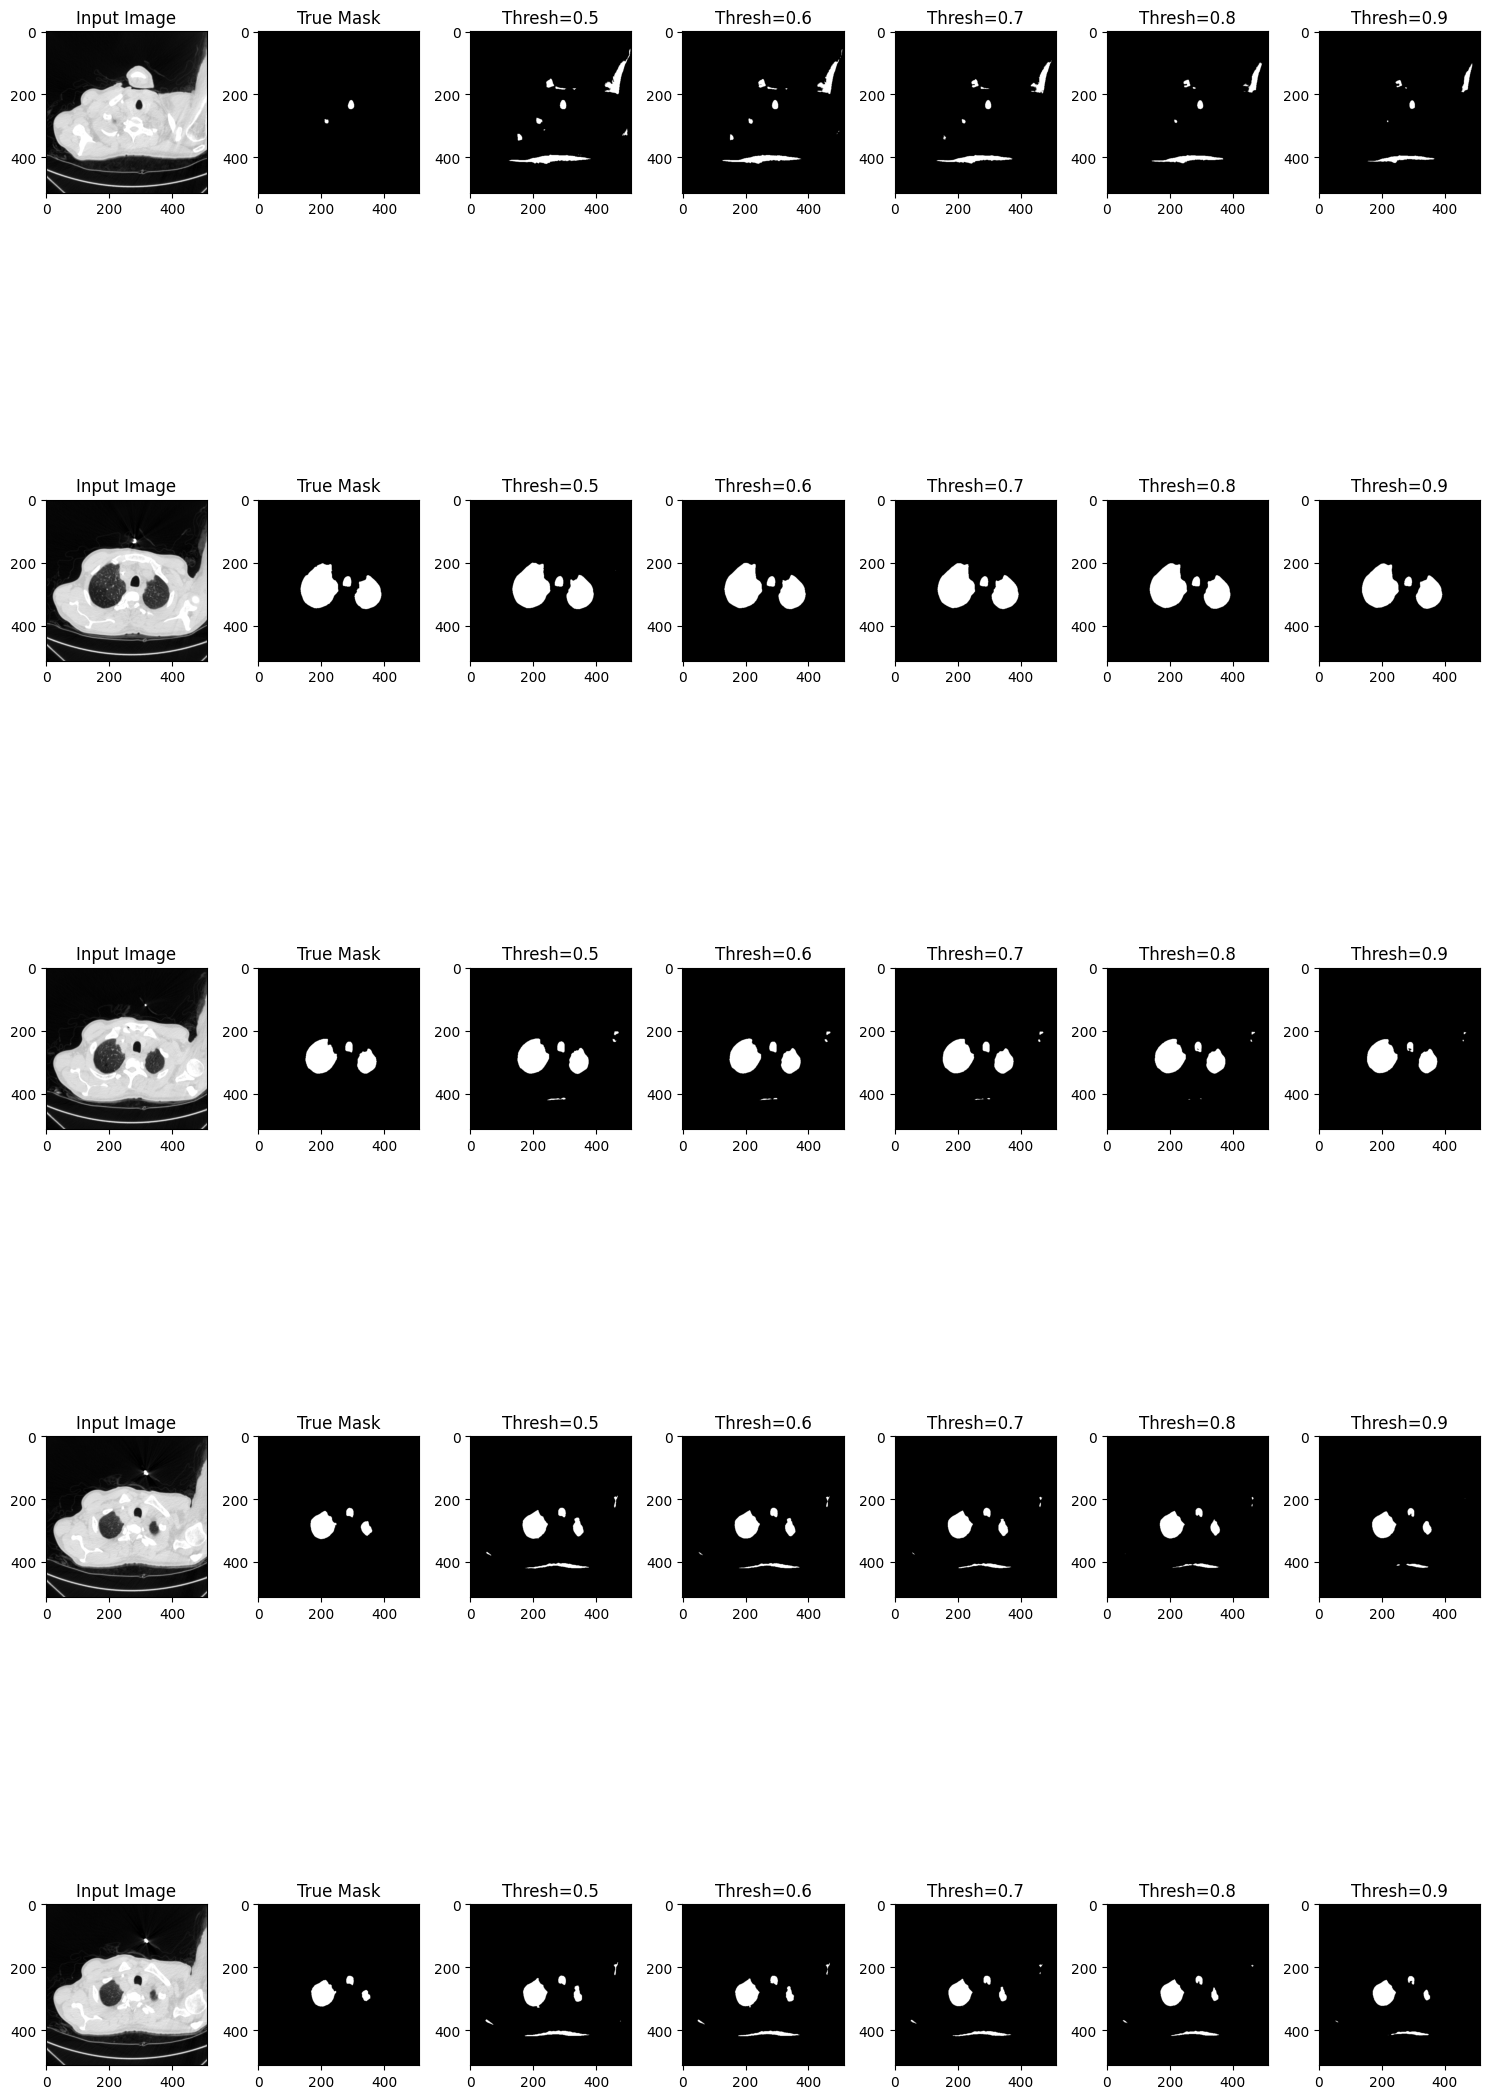

In [ ]:
plot_images_with_masks(visualize_images, visualize_true_masks, pred_masks, thresholds)


**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# !pip install efficientnet
# !pip install tensorflow_addons

In [5]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  80.7M      0  0:00:09  0:00:09 --:--:-- 95.1M


In [6]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [7]:
# Delete Corrupted Images
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [8]:
rescale_factor = 1.0 / 255.0

train_img_gen = ImageDataGenerator(
    rescale=rescale_factor,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

val_img_gen = ImageDataGenerator(rescale=rescale_factor, validation_split=0.2)

# Create training and validation datasets
train_ds = train_img_gen.flow_from_directory(
    directory='PetImages',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    subset='training',
    seed=42
)

val_ds = val_img_gen.flow_from_directory(
    directory='PetImages',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    subset='validation',
    seed=42
)


Found 18729 images belonging to 2 classes.
Found 4681 images belonging to 2 classes.


### Preview the Images

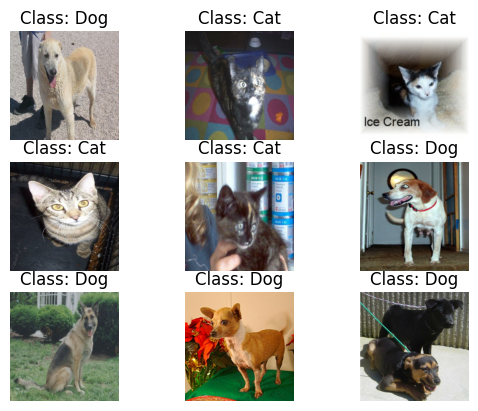

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

## `+` Set Global Parameters

In [10]:
# Hyperparameters
BATCH_SIZE  =128
EPOCHS      =50

## `i` Model Design

In [9]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224, 3))
conv_base.trainable=False

16804768/16804768 [==============================] - 0s 0us/step


In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),

    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [13]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

# metrics = [
#     CategoricalAccuracy(),
#     F1Score(num_classes=1),
#     Precision(),
#     Recall(),
# #     AUC()
# ]

model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=40, batch_size=128,
                  validation_data=val_ds,callbacks= callbacks
                             )

Epoch 1/40
147/147 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9570

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 298s 2s/step - loss: 0.1109 - accuracy: 0.9570 - val_loss: 0.0707 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 2/40
147/147 [==============================] - 272s 2s/step - loss: 0.0508 - accuracy: 0.9814 - val_loss: 0.0627 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/40
147/147 [==============================] - 272s 2s/step - loss: 0.0397 - accuracy: 0.9861 - val_loss: 0.0534 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 4/40
147/147 [==============================] - 273s 2s/step - loss: 0.0328 - accuracy: 0.9879 - val_loss: 0.0504 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 5/40
147/147 [==============================] - 273s 2s/step - loss: 0.0276 - accuracy: 0.9900 - val_loss: 0.0546 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 6/40
147/147 [==============================] - 270s 2s/step - loss: 0.0242 - accuracy: 0.9916 - val_loss: 0.0716 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 7/40
147/147 [==============================] - 271s 2s/step - loss: 

## `iii` Model Evaluation

In [16]:
# Evaluate on the validation dataset
evaluation = model.evaluate(val_ds, callbacks=callbacks)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])

37/37 [==============================] - 15s 389ms/step - loss: 0.0559 - accuracy: 0.9825
Evaluation Loss: 0.05591071397066116
Evaluation Accuracy: 0.982482373714447


## `iv` Result Visualization

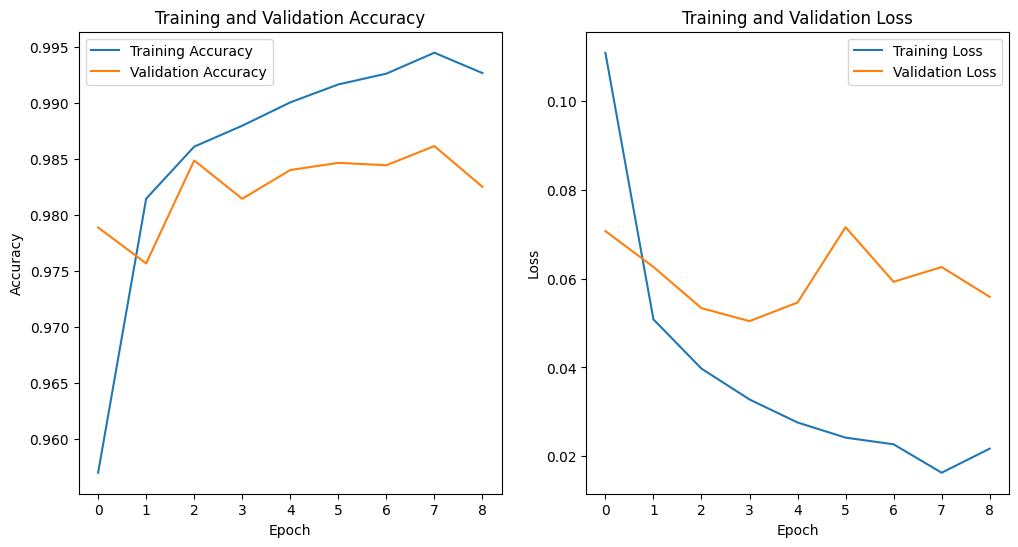

In [17]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

In [19]:
class_indices = train_ds.class_indices

#class indices
print("Class Indices:", class_indices)

Class Indices: {'Cat': 0, 'Dog': 1}


4/4 [==============================] - 3s 40ms/step


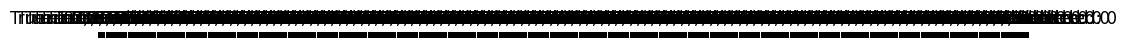

In [21]:
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {true_labels[i]}, Predicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.show()

val_images, val_labels = next(val_ds)

val_images = val_images.astype('float32') / 255.0

# class of validation samples
val_predictions = model.predict(val_images)
val_predicted_labels = [int(round(pred.item())) for pred in val_predictions]

plot_images(val_images, val_labels, val_predicted_labels)


In [26]:
def classify_image_from_url(image_url, model):
    image = load_img(image_url, target_size=(224, 224))
    image = img_to_array(image) / 255.0  # Rescaleing
    image = np.expand_dims(image, axis=0)

    # Predict the class of the image
    prediction = model.predict(image)
    predicted_label = 'Cat' if prediction < 0.5 else 'Dog'

    # Plot the input image
    plt.imshow(image[0])
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 28ms/step


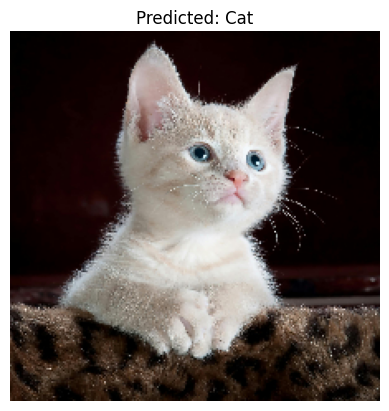

In [27]:
image_url = '/content/pexels-pixabay-45201.jpg'
classify_image_from_url(image_url, model)

1/1 [==============================] - 0s 28ms/step


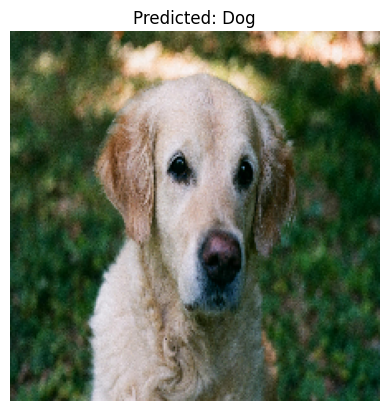

In [28]:
image_url = '/content/pexels-cristina-anskaja-🇺🇦-10433404.jpg'
classify_image_from_url(image_url, model)

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$